# Data science job postings on glassdoor

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
uncleaned_df = pd.read_csv("C:\\Users\\MGC\\Downloads\\datasciencejobposting_dataset\\archive (13)\\Uncleaned_DS_jobs.csv")

### Data description

In [3]:
uncleaned_df.head()

,index,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors
0,0,Sr Data Scientist,$137K-$171K (Glassdoor est.),Description\n\nThe Senior Data Scientist is re...,3.1,Healthfirst\n3.1,"New York, NY","New York, NY",1001 to 5000 employees,1993,Nonprofit Organization,Insurance Carriers,Insurance,Unknown / Non-Applicable,"EmblemHealth, UnitedHealth Group, Aetna"
1,1,Data Scientist,$137K-$171K (Glassdoor est.),"Secure our Nation, Ignite your Future\n\nJoin ...",4.2,ManTech\n4.2,"Chantilly, VA","Herndon, VA",5001 to 10000 employees,1968,Company - Public,Research & Development,Business Services,$1 to $2 billion (USD),-1
2,2,Data Scientist,$137K-$171K (Glassdoor est.),Overview\n\n\nAnalysis Group is one of the lar...,3.8,Analysis Group\n3.8,"Boston, MA","Boston, MA",1001 to 5000 employees,1981,Private Practice / Firm,Consulting,Business Services,$100 to $500 million (USD),-1
3,3,Data Scientist,$137K-$171K (Glassdoor est.),JOB DESCRIPTION:\n\nDo you have a passion for ...,3.5,INFICON\n3.5,"Newton, MA","Bad Ragaz, Switzerland",501 to 1000 employees,2000,Company - Public,Electrical & Electronic Manufacturing,Manufacturing,$100 to $500 million (USD),"MKS Instruments, Pfeiffer Vacuum, Agilent Tech..."
4,4,Data Scientist,$137K-$171K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee"


In [4]:
uncleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              672 non-null    int64  
 1   Job Title          672 non-null    object 
 2   Salary Estimate    672 non-null    object 
 3   Job Description    672 non-null    object 
 4   Rating             672 non-null    float64
 5   Company Name       672 non-null    object 
 6   Location           672 non-null    object 
 7   Headquarters       672 non-null    object 
 8   Size               672 non-null    object 
 9   Founded            672 non-null    int64  
 10  Type of ownership  672 non-null    object 
 11  Industry           672 non-null    object 
 12  Sector             672 non-null    object 
 13  Revenue            672 non-null    object 
 14  Competitors        672 non-null    object 
dtypes: float64(1), int64(2), object(12)
memory usage: 78.9+ KB


### Data preprocessing and feature engineering

In [7]:
# Function to extract company name from string
def extract_company_name(company_string):
    return company_string.split("\n")[0] if isinstance(company_string, str) else company_string

# Function to calculate company age
def calculate_company_age(year_founded):
    return 2023 - year_founded

# Function to check for keywords in job description
def check_keyword_in_description(description, keywords):
    return 1 if any(keyword in description for keyword in keywords) else 0

# Applying functions to create new columns
uncleaned_df["Company Name"] = uncleaned_df["Company Name"].apply(extract_company_name)
uncleaned_df["Company_age"] = uncleaned_df["Founded"].apply(calculate_company_age)

keywords = {
    'sql': ['sql'],
    'python': ['python'],
    'aws': ['aws'],
    'hadoop/spark': ['hadoop', 'spark'],
    'machine_learning': ['machine learning', 'ml'],
    'Power BI/Tableau': ['powerbi', 'tableau', 'power bi'],
    'API': ['Flask', 'api']
}

for col_name, kw_list in keywords.items():
    uncleaned_df[col_name] = uncleaned_df['Job Description'].apply(lambda x: check_keyword_in_description(x, kw_list))

#### Cleaning the salary column


In [10]:
for idx in uncleaned_df.index:
    matches = re.findall(r'\d+', uncleaned_df.at[idx, 'Salary Estimate'])

    if len(matches) == 2:
        uncleaned_df.at[idx, 'Salary Estimate'] = f"{matches[0]}-{matches[1]}"
        
uncleaned_df['min_salary'] = 0  
uncleaned_df['max_salary'] = 0

for idx, row in uncleaned_df.iterrows():
    matches = re.findall(r'\d+', row['Salary Estimate'])

    if len(matches) == 2:
        uncleaned_df.at[idx, 'min_salary'] = int(matches[0])
        uncleaned_df.at[idx, 'max_salary'] = int(matches[1])

#### Cleaning the revenue column


In [11]:
def clean_revenue(revenue_str):
    if re.match(r'\$[\d,]+\s*to\s*\$[\d,]+\s*(billion|million)?\s*\(USD\)', revenue_str):
        matches = re.findall(r'\$([\d,]+)\s*to\s*\$([\d,]+)\s*(billion|million)?\s*\(USD\)', revenue_str)
        if matches:
            min_value = matches[0][0].replace(',', '')
            max_value = matches[0][1].replace(',', '')
            unit = matches[0][2]
            if unit == 'billion':
                min_value = int(min_value) * 1000
                max_value = int(max_value) * 1000
            elif unit == 'million':
                min_value = int(min_value)
                max_value = int(max_value)
            return f"{min_value}-{max_value}"
    return "Invalid"

# Applying the clean_revenue function to the DataFrame
uncleaned_df['Avg_Revenue(in_millions_usd)'] = uncleaned_df['Revenue'].apply(clean_revenue)


#### Cleaning organisation size


In [16]:
def clean_employees(employees_str):
    matches = re.findall(r'(\d+)\s*to\s*(\d+)\s*employees', employees_str)
    if matches:
        min_value = int(matches[0][0])
        max_value = int(matches[0][1])
        return f"{min_value}-{max_value}"
    
    matches = re.findall(r'(\d+)\+\s*employees', employees_str)
    if matches:
        min_value = int(matches[0])
        return f"{min_value}+"
    
    return "Invalid"

# Applying the clean_employees function to the DataFrame
uncleaned_df['Company_Size'] = uncleaned_df['Size'].apply(clean_employees)
uncleaned_df.replace("-1", np.nan, inplace=True)
uncleaned_df.replace(-1.0, np.nan, inplace=True)
uncleaned_df.replace(-1, 0, inplace=True)
uncleaned_df.dropna(thresh=7, inplace=True)

#### Grouping the industries together

In [17]:
industry_groups = {
    'Technology': ['Tech', 'Computer Hardware & Software', 'Internet', 'Video Games', 'Telecommunications Services',
                   'Cable, Internet & Telephone Providers', 'Telecommunications Manufacturing', 'IT Services'],
    'Finance': ['Finance', 'Investment Banking & Asset Management', 'Banks & Credit Unions', 'Lending'],
    'Healthcare': ['Healthcare', 'Health Care Services & Hospitals'],
    'Manufacturing': ['Electrical & Electronic Manufacturing', 'Biotech & Pharmaceuticals',
                       'Consumer Electronics & Appliances Stores', 'Enterprise Software & Network Solutions',
                       'Consumer Products Manufacturing', 'Industrial Manufacturing',
                       'Food & Beverage Manufacturing', 'Miscellaneous Manufacturing', 'Transportation Equipment Manufacturing'],
    'Consulting & Services': ['Consulting', 'Federal Agencies', 'Express Delivery Services', 'Staffing & Outsourcing',
                              'Insurance Agencies & Brokerages', 'Transportation Management', 'Architectural & Engineering Services',
                              'Other Retail Stores', 'State & Regional Agencies', 'Financial Transaction Processing',
                              'Timber Operations', 'Colleges & Universities', 'Travel Agencies', 'Accounting',
                              'Logistics & Supply Chain', 'Farm Support Services', 'Social Assistance', 'Construction',
                              'Department, Clothing, & Shoe Stores', 'Publishing', 'Wholesale'],
    'Energy & Utilities': ['Energy', 'Utilities', 'Oil & Gas Services'],
    'Real Estate & Property': ['Real Estate', 'Venture Capital & Private Equity'],
    'Travel & Hospitality': ['Hotels, Motels, & Resorts'],
    'Miscellaneous': ['Rail']
}

# Grouping industries by broader categories
def group_industry(industry):
    for group, industries in industry_groups.items():
        if industry in industries:
            return group
    return 'Other'

uncleaned_df['Industry Group'] = uncleaned_df['Industry'].apply(group_industry)

In [18]:
uncleaned_df["Founded"].replace(np.nan, 0, inplace= True)
uncleaned_df["Founded"] = uncleaned_df["Founded"].astype(int)

#### Encoding revenue and Orgsize

In [19]:
custom_ordinal_mapping = {
    'Invalid': 0,
    '1-5': 1,
    '5-10': 2,
    '10-25': 3,
    '25-50': 4,
    '50-100': 5,
    '100-500': 6,
    '1000-2000': 7,
    '2000-5000': 8,
    '5000-10000': 9
}

# Applyng the custom ordinal mapping to create a new column
uncleaned_df['Ordinal_Revenue'] = uncleaned_df['Avg_Revenue(in_millions_usd)'].map(custom_ordinal_mapping)


In [20]:
custom_ordinal_mapping = {
    'Invalid': 0,
    '1-50': 1,
    '51-200': 2,
    '201-500': 3,
    '501-1000': 4,
    '1001-5000': 5,
    '5001-10000': 6,
    '10000+': 7
}

# Applying the custom ordinal mapping to create a new column
uncleaned_df['Ordinal_Company_Size'] = uncleaned_df['Company_Size'].map(custom_ordinal_mapping)



### Dropping some columns 

In [21]:
uncleaned_df.drop(["Job Description", "index", "Revenue", "Size"], axis=1, inplace=True)

## Exploratory Data Analysis

C:\Users\MGC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Counting different types of Organisation present ')

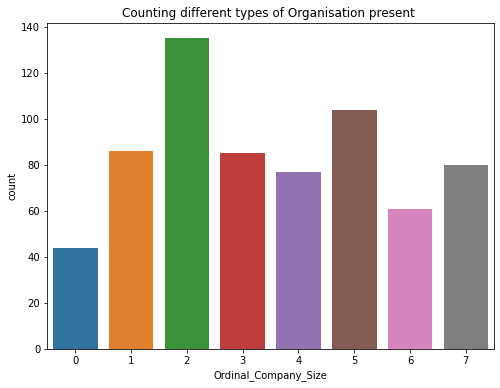

In [23]:
plt.figure(figsize=(8, 6))
sns.countplot(uncleaned_df.Ordinal_Company_Size)
plt.title("Counting different types of Organisation present ")

### Segmenting Companies by Revenue and Required Skills in Job Descriptions

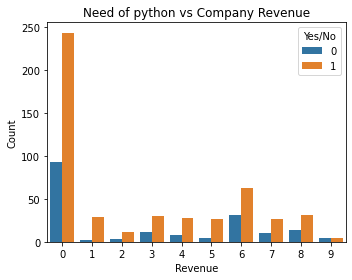

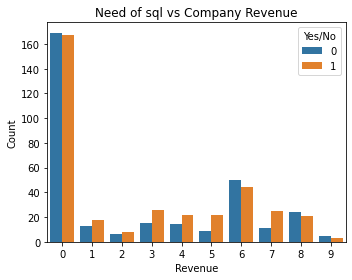

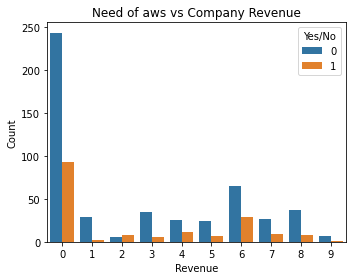

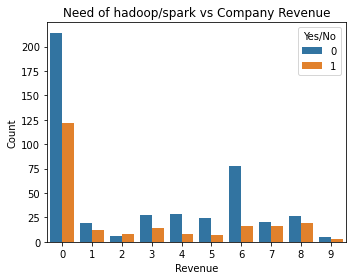

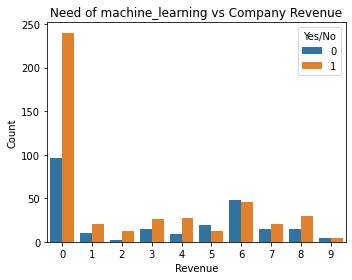

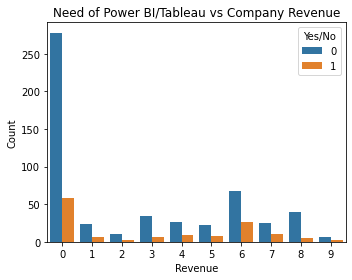

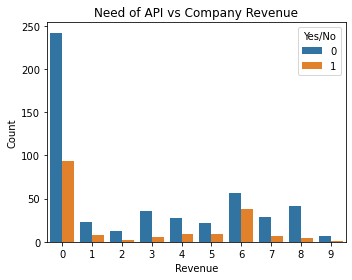

In [20]:
columns_to_compare = ['python', 'sql', 'aws', 'hadoop/spark', 'machine_learning','Power BI/Tableau', 'API']

# Creating separate bar plots for each column
for column in columns_to_compare:
    plt.figure(figsize=(5, 4))
    sns.countplot(data=uncleaned_df, x='Ordinal_Revenue', hue=column)
    plt.title(f'Need of {column} vs Company Revenue')
    plt.xlabel('Revenue')
    plt.ylabel('Count')
    plt.legend(title='Yes/No')
    plt.tight_layout()
    plt.show()

### Top skills needed

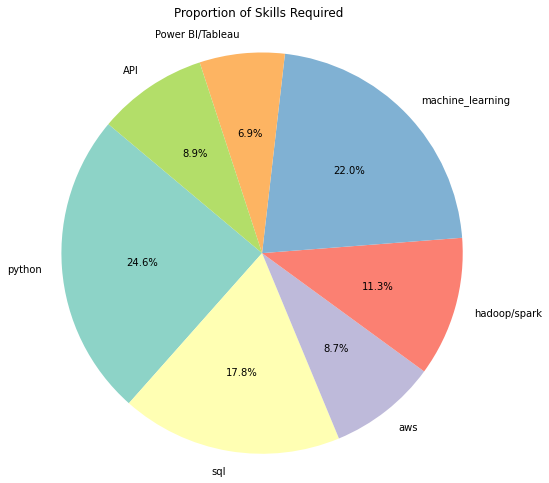

In [21]:
skill_columns = ['python', 'sql', 'aws', 'hadoop/spark', 'machine_learning', 'Power BI/Tableau', 'API']

# Creating a subset DataFrame containing only the skill columns
skill_df = uncleaned_df[skill_columns]

# Counting the occurrences of value 1 in each skill column
skill_counts = skill_df.eq(1).sum()

# Create a bar ploting a piechart
plt.figure(figsize=(8, 8))
plt.pie(skill_counts, labels=skill_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Set3.colors)
plt.title('Proportion of Skills Required \n')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Variation in Minimum Salary Across Different Company Sizes

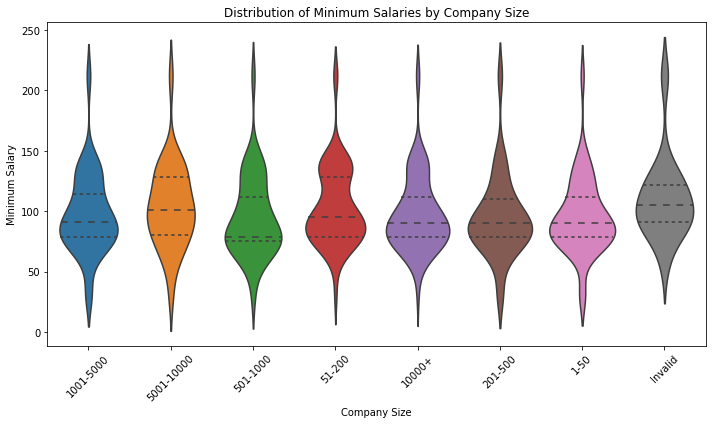

In [22]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Company_Size', y='min_salary', data=uncleaned_df, inner='quartiles')
plt.title('Distribution of Minimum Salaries by Company Size')
plt.xlabel('Company Size')
plt.ylabel('Minimum Salary')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Skills needed across different industries

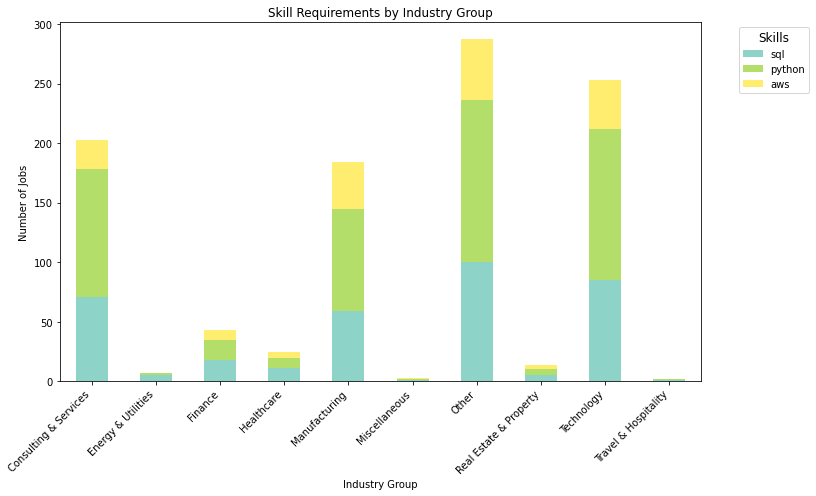

In [31]:
grouped_skills = uncleaned_df.groupby('Industry Group')[['sql', 'python', 'aws']].sum()

# Creating a stacked bar plot using matplotlib
fig, ax = plt.subplots(figsize=(10, 7))
grouped_skills.plot(kind='bar', stacked=True, colormap='Set3', ax=ax)
plt.title('Skill Requirements by Industry Group')
plt.xlabel('Industry Group')
plt.ylabel('Number of Jobs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Adjusting the font size of the legend title
legend = ax.legend(title='Skills', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.setp(legend.get_title(), fontsize='12')

plt.show()


### Top 10 Job Listings by Location

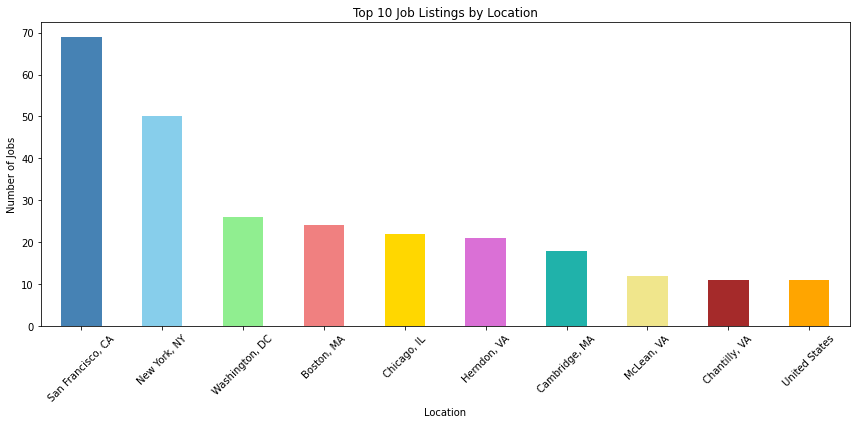

In [28]:
plt.figure(figsize=(12, 6))
location_counts = uncleaned_df['Location'].value_counts().head(10)  # Display top 10 locations
location_counts.plot(kind='bar', color=['steelblue','skyblue', 'lightgreen', 'lightcoral', 'gold', 'orchid', 'lightseagreen', 'khaki','brown','orange'])
plt.title('Top 10 Job Listings by Location')
plt.xlabel('Location')
plt.ylabel('Number of Jobs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
